<a href="https://colab.research.google.com/github/Kdavis2025/Automating-Compliance-AI-and-Machine-Learning-Approaches-to-Achieviing-CMMC-2.0-Certification/blob/main/Threat_Detection_and_Incident_Response_Automation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Unsupervised training set shape: (1050, 5)
Supervised train/test split shapes: (800, 5) (200, 5)
IsolationForest trained. Sample anomaly labels (−1 anomaly, 1 normal): [1 1 1 1 1 1 1 1 1 1]

RandomForest Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       156
           1       1.00      1.00      1.00        44

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

Confusion Matrix:
 [[156   0]
 [  0  44]]

[ALERT] Anomalous activity detected in log #4: [ 8.79192293  4.14843834 12.01218198 10.30096379 11.00549363]
[ALERT] Confirmed intrusion detected.
[ACTION] Isolating host Host004 from the network. (CMMC: SC-07, IR-4)
[ACTION] Revoking credentials for user User00004. (CMMC: AC-02, IA-05)
[REPORT] {
  "log_index": 4,
  "features": [
    8.791922928308475,
    4.148438339424083,
    12.012181984741046,

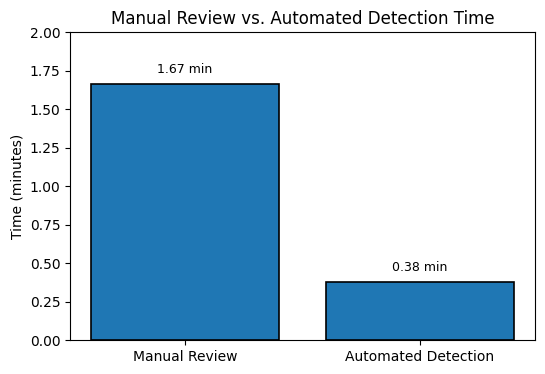

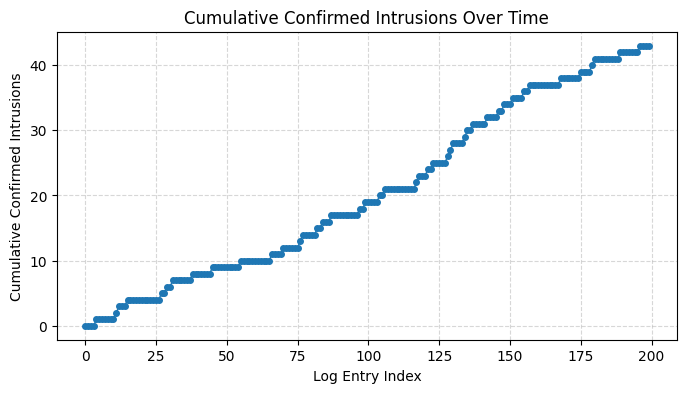

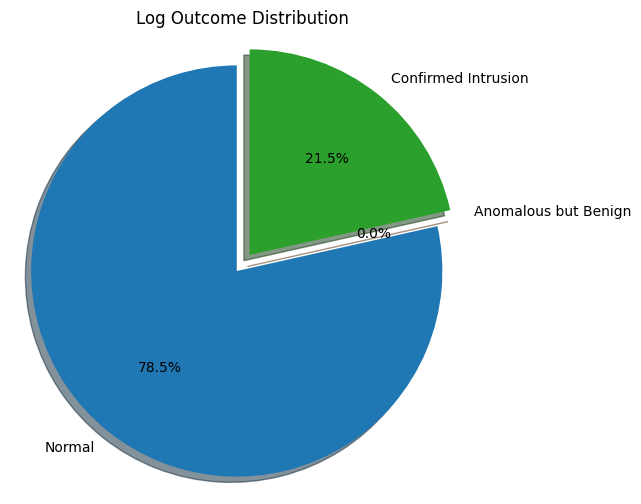

In [ ]:
# -----------------------------
# 1. Notebook Setup
# -----------------------------
# Ensure all required libraries are installed.
!pip install scikit-learn pandas matplotlib

# STANDARD IMPORTS
import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# -----------------------------
# 2. Simulate or Load Log & Network Traffic Data
# -----------------------------
# 2.1. Simulate Unsupervised Training Data
np.random.seed(42)

# Simulate 1000 “normal” log entries with 5 numeric features
X_train_unsup = np.random.normal(loc=0.0, scale=1.0, size=(1000, 5))

# Introduce a few extreme outliers for “rare anomalies”
n_outliers = 50
outliers = np.random.normal(loc=10.0, scale=5.0, size=(n_outliers, 5))
X_train_unsup = np.vstack([X_train_unsup, outliers])

# 2.2. Simulate Supervised Training Data
#  - 0 = benign, 1 = intrusion
# We create 800 benign samples, 200 intrusion samples
X_benign = np.random.normal(loc=0.0, scale=1.0, size=(800, 5))
y_benign = np.zeros((800,), dtype=int)

X_intrusion = np.random.normal(loc=8.0, scale=3.0, size=(200, 5))
y_intrusion = np.ones((200,), dtype=int)

X_train_sup = np.vstack([X_benign, X_intrusion])
y_train_sup = np.concatenate([y_benign, y_intrusion])

# Split supervised data into train/test sets (80/20 split)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_train_sup, y_train_sup, test_size=0.2, random_state=42
)

print("Unsupervised training set shape:", X_train_unsup.shape)
print("Supervised train/test split shapes:", X_train_clf.shape, X_test_clf.shape)

# -----------------------------
# 3. Model Training
# -----------------------------
# 3.1. Isolation Forest (Unsupervised)
anomaly_detector = IsolationForest(
    n_estimators=100,
    contamination=float(n_outliers) / (len(X_train_unsup)),  # approx. fraction of outliers
    random_state=42
)
anomaly_detector.fit(X_train_unsup)

# Test IsolationForest on the unsupervised set
scores = anomaly_detector.decision_function(X_train_unsup)
labels_if = anomaly_detector.predict(X_train_unsup)
# labels_if == -1 => anomaly; 1 => normal
print("IsolationForest trained. Sample anomaly labels (−1 anomaly, 1 normal):", labels_if[:10])

# 3.2. RandomForestClassifier (Supervised)
intrusion_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42
)
intrusion_classifier.fit(X_train_clf, y_train_clf)

# Evaluate on test set
y_pred_clf = intrusion_classifier.predict(X_test_clf)
print("\nRandomForest Classification Report:\n", classification_report(y_test_clf, y_pred_clf))
print("Confusion Matrix:\n", confusion_matrix(y_test_clf, y_pred_clf))

# -----------------------------
# 4. Simulate a Live Log-Stream
# -----------------------------
def simulate_log_stream(n_entries=200, interval=1.0):
    """
    Generator that yields one log-feature vector every `interval` seconds.
    - 80% chance of benign-like features
    - 20% chance of intrusion-like features
    """
    for _ in range(n_entries):
        if np.random.rand() < 0.2:
            # Intrusion-like sample
            sample = np.random.normal(loc=8.0, scale=3.0, size=(5,))
        else:
            # Benign-like sample
            sample = np.random.normal(loc=0.0, scale=1.0, size=(5,))
        yield sample
        time.sleep(interval)  # simulate real-time delay

# -----------------------------
# 5. Automated Playbooks & Incident Reporting
# -----------------------------
def isolate_host(host_id):
    """
    [ACTION] Isolate host from the network.
    This simulates a network orchestration API call in a CMMC environment (e.g., SC-07).
    """
    print(f"[ACTION] Isolating host {host_id} from the network. (CMMC: SC-07, IR-4)")

def revoke_credentials(user_id):
    """
    [ACTION] Revoke credentials for a given user.
    Simulates calling an identity management API (e.g., IAM revoke).
    Satisfies NIST SP 800-171 IR-4: Incident Handling, PR.AC: Access Control.
    """
    print(f"[ACTION] Revoking credentials for user {user_id}. (CMMC: AC-02, IA-05)")

incident_list = []  # Will accumulate dicts for each incident

def generate_incident_report(details):
    """
    [REPORT] Append a JSON-like incident to incident_list.
    In a production SIEM, you’d send this via syslog/REST to a central system.
    """
    timestamp = time.time()
    record = {
        "timestamp": timestamp,
        "details": details
    }
    incident_list.append(record)
    # We also print a summary for demonstration:
    print(f"[REPORT] {json.dumps(details, indent=2)}")

# -----------------------------
# 6. Threat-Detection Loop
# -----------------------------
num_entries_processed = 0
num_anomalies_detected = 0
num_intrusions_confirmed = 0

# For “time saved” calculation:
manual_check_time_per_log = 0.5  # seconds

start_time_auto = time.time()

for idx, log_features in enumerate(simulate_log_stream(n_entries=200, interval=0.1)):
    num_entries_processed += 1
    vf = log_features.reshape(1, -1)

    # 1) Unsupervised anomaly detection
    anomaly_label = anomaly_detector.predict(vf)[0]  # -1 => anomaly, 1 => normal
    if anomaly_label == -1:
        num_anomalies_detected += 1
        print(f"\n[ALERT] Anomalous activity detected in log #{idx}:", log_features)

        # 2) Supervised classification
        threat_label = intrusion_classifier.predict(vf)[0]  # 0 => benign, 1 => intrusion
        if threat_label == 1:
            num_intrusions_confirmed += 1
            print("[ALERT] Confirmed intrusion detected.")

            # 3) Automated Playbook
            host_id = f"Host{idx:03d}"
            user_id = f"User{idx:05d}"
            isolate_host(host_id)       # CMMC: “System and Communications Protection (SC-07)”
            revoke_credentials(user_id) # CMMC: “Access Control (AC-02, IA-05)”

            # 4) Generate Incident Report
            details = {
                "log_index": idx,
                "features": log_features.tolist(),
                "actions_taken": ["Isolate Host", "Revoke Credentials"],
                "detected_by": "IsolationForest+RandomForest",
                "timestamp": time.time()
            }
            generate_incident_report(details)
        else:
            print("[INFO] Anomalous but classified as benign noise. Continuing monitoring.")
    # else: normal activity, do nothing

end_time_auto = time.time()
total_time_auto = end_time_auto - start_time_auto

# 6.2. Metrics Summary
print("\n=== METRICS SUMMARY ===")
print(f"Total log entries processed: {num_entries_processed}")
print(f"Total anomalies flagged: {num_anomalies_detected}")
print(f"Total intrusions confirmed & handled: {num_intrusions_confirmed}")
print(f"Auto-run total elapsed time (seconds): {total_time_auto:.2f}")

time_manual = num_entries_processed * manual_check_time_per_log
print(f"Manual review time estimate (seconds): {time_manual:.2f}")

time_saved = time_manual - total_time_auto
print(f"Hypothetical time saved by automation (seconds): {time_saved:.2f}")

# -----------------------------
# 7. Visualizing Efficacy: Graphs & Charts
# -----------------------------
# 7.1. Prepare Data for Charts
manual_mins = time_manual / 60.0
auto_mins = total_time_auto / 60.0

chart1_labels = ["Manual Review", "Automated Detection"]
chart1_times = [manual_mins, auto_mins]

cumulative_intrusions = []
count = 0
for idx in range(num_entries_processed):
    is_intrusion = any(r["details"]["log_index"] == idx for r in incident_list)
    if is_intrusion:
        count += 1
    cumulative_intrusions.append(count)

chart2_x = list(range(num_entries_processed))
chart2_y = cumulative_intrusions

n_normal = num_entries_processed - num_anomalies_detected
n_anomalous_but_benign = num_anomalies_detected - num_intrusions_confirmed
n_intrusions = num_intrusions_confirmed

chart3_labels = ["Normal", "Anomalous but Benign", "Confirmed Intrusion"]
chart3_sizes = [n_normal, n_anomalous_but_benign, n_intrusions]

# 7.2. Plot Bar Chart: Manual vs. Automated Time
plt.figure(figsize=(6,4))
bars = plt.bar(chart1_labels, chart1_times, edgecolor='black', linewidth=1.2)
plt.ylabel("Time (minutes)")
plt.title("Manual Review vs. Automated Detection Time")
for bar, t in zip(bars, chart1_times):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.05, f"{t:.2f} min",
             ha='center', va='bottom', fontsize=9)
plt.ylim(0, max(chart1_times)*1.2)
plt.show()

# 7.3. Plot Line Chart: Cumulative Intrusions Detected
plt.figure(figsize=(8,4))
plt.plot(chart2_x, chart2_y, marker='o', linestyle='-', linewidth=1, markersize=4)
plt.xlabel("Log Entry Index")
plt.ylabel("Cumulative Confirmed Intrusions")
plt.title("Cumulative Confirmed Intrusions Over Time")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# 7.4. Plot Pie Chart: Log Outcome Proportions
plt.figure(figsize=(6,6))
explode = (0.05, 0.05, 0.05)
patches, texts, autotexts = plt.pie(
    chart3_sizes,
    labels=chart3_labels,
    autopct="%1.1f%%",
    startangle=90,
    explode=explode,
    shadow=True
)
plt.title("Log Outcome Distribution")
plt.axis('equal')
plt.show()
